In [11]:
using Plots
using Distributions
using Random
using LinearAlgebra
using Printf

In [8]:
# Simulates a single realization for 60 days
function simulate_realization(M, s1, s2)
    # Number of days
    days = 60
    
    # State
    # number of worn machines
    W = zeros(Int, days)
    # number of broken machines
    B = zeros(Int, days)
    
    # probability of new -> worn
    p12 = (1/60) + (1/200 - 1/60) * sqrt(1 - ((10 - s1) / 10)^2)
    # probability of worn -> broken
    p23 = (1/30) + (1/100 - 1/30) * sqrt(1 - ((10 - s2) / 10)^2)
    
    # Simulate all days
    for i in 1:(days-1)
        B12 = rand(Binomial(M-W[i]-B[i], p12))
        B23 = rand(Binomial(W[i], p23))
        
        W[i+1] = W[i] + B12 - B23
        B[i+1] = B[i] +     + B23 - B[i]
    end
    
    # Calculate the number of new machines every day
    N = M * ones(days) - W - B
    
    N, W, B
end

# Calculate the cumulative gain over 60 days
function cumulative_gain(M, B)
    total = 0.0
    for day in 1:60
        total += (1 * (M - B[day]) - 90 * B[day] - s1 - s2)
    end
    return total
end

# Performs a simulation experiment that calculates the gain, by
# averaging 10,000 realizations
function simulate(M, s1, s2)
    gain = 0.0
    
    realizations = 10_000
    for _ in 1:realizations
        N, W, B = simulate_realization(M, s1, s2)
        gain += cumulative_gain(M, B)
    end
    
    return gain / realizations
end

# Total number of machines
M = 2_000

2000

In [9]:
# Parameters
# money spent daily for maintainance of worn machines
s1 = 4
# money spent daily for maintainance of broken machines
s2 = 6
@time simulate(M, s1, s2)

  0.365112 seconds (2.59 M allocations: 76.194 MiB, 3.75% gc time)


99912.2954

---

In [12]:
X = []
y = []
@time for j=2:2:10, k=2:2:10
    gain = simulate(M, j, k)
    push!(X, [j, k])
    push!(y, [gain])
    println("($j, $k) = $(@sprintf("%3d" ,gain))")
end

(2, 2) = 83609
(2, 4) = 90274
(2, 6) = 94651
(2, 8) = 97224
(2, 10) = 98051
(4, 2) = 91288
(4, 4) = 96495
(4, 6) = 99957
(4, 8) = 101922
(4, 10) = 102568
(6, 2) = 96030
(6, 4) = 100338
(6, 6) = 103174
(6, 8) = 104825
(6, 10) = 105386
(8, 2) = 98693
(8, 4) = 102497
(8, 6) = 105029
(8, 8) = 106480
(8, 10) = 106966
(10, 2) = 99553
(10, 4) = 103199
(10, 6) = 105586
(10, 8) = 107006
(10, 10) = 107477
  6.485861 seconds (61.76 M allocations: 1.704 GiB, 6.53% gc time)


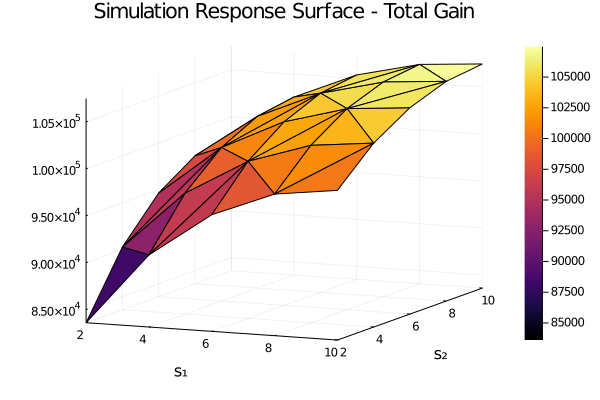

In [13]:
surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface - Total Gain", xlabel="s₁", ylabel="s₂", margin=5Plots.mm)

---

In [15]:
# Define the nonlinearity used in our network and its derivative
sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x) * (1 - sigma(x))

y_mean = mean(y)[1]
y_std = std(y)[1]

function z_transform(yi)
    (yi - y_mean) / y_std
end

function inv_z_transform(yi)
    (yi * y_std) + y_mean
end

# Compute the forward pass of a 1-hidden-layer neural network
function nn(x, W1, b1, W2, b2)
    z1 = W1 * x + b1
    a1 = sigma.(z1)
    z2 = W2 * a1 + b2
    a2 = z2
    return a2[1]
end

# Compute the Mean Squared Error of the NN's predictions for all samples
function compute_loss(X, y, W1, b1, W2, b2)
    loss = 0.0
    for (x, y_true) in zip(X, y)
        # re-scale the network's predictions back to original mean, std. dev.
        y_true = z_transform.(y_true)
        y_hat = nn(x, W1, b1, W2, b2)

        loss += (y_hat[1] - y_true[1])^2
    end
    loss /= (2 * size(X, 1))
    return loss
end

Random.seed!(1234);

# Hyperparameters
# Learning Rate/Step Size
mu = 5e-3

# Parameters and weights/biases initialization
INPUT_SIZE = 2
HIDDEN_LAYER_SIZE = 100
W1 = randn(HIDDEN_LAYER_SIZE, INPUT_SIZE)
b1 = randn(HIDDEN_LAYER_SIZE, 1)

OUTPUT_LAYER_SIZE = 1
W2 = randn(OUTPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE)
b2 = randn(OUTPUT_LAYER_SIZE, 1)

# Training loop
for it in 1:10_000
    # For every sample in the training dataset
    for (x, y_true) in zip(X, y)
        # z-transform the target before training the network with it
        y_true = z_transform.(y_true)
        
        # Forward step to evaluate intermediate results
        z1 = W1 * x + b1
        a1 = sigma.(z1)
        z2 = W2 * a1 + b2
        a2 = z2

        # Backward step to evaluate parameter derivatives w.r.t. loss
        # d(loss)/d(z2) is `dz2`
        dz2 = a2 - y_true
        dW2 = dz2 * a1'
        db2 = dz2

        dz1 = (W2' * dz2) .* sigma_prime.(z1)
        dW1 = dz1 * x'
        db1 = dz1

        # Steepest descent to find optimal parameters
        W2 -= mu * dW2
        b2 -= mu * db2

        W1 -= mu * dW1
        b1 -= mu * db1
    end
    
    # Learning rate's geometric decay
    mu *= 0.9995
    
    if it % 200 == 0
        println("[$it]: $(@sprintf("%.3E", compute_loss(X, y, W1, b1, W2, b2))), mu=$(@sprintf("%.3E", mu))")
    end
end

[200]: 1.148E-03, mu=4.524E-03
[400]: 6.184E-04, mu=4.093E-03
[600]: 4.721E-04, mu=3.704E-03
[800]: 4.019E-04, mu=3.351E-03
[1000]: 3.589E-04, mu=3.032E-03
[1200]: 3.290E-04, mu=2.744E-03
[1400]: 3.068E-04, mu=2.482E-03
[1600]: 2.898E-04, mu=2.246E-03
[1800]: 2.763E-04, mu=2.032E-03
[2000]: 2.655E-04, mu=1.839E-03
[2200]: 2.567E-04, mu=1.664E-03
[2400]: 2.494E-04, mu=1.506E-03
[2600]: 2.433E-04, mu=1.362E-03
[2800]: 2.382E-04, mu=1.233E-03
[3000]: 2.339E-04, mu=1.115E-03
[3200]: 2.303E-04, mu=1.009E-03
[3400]: 2.271E-04, mu=9.130E-04
[3600]: 2.244E-04, mu=8.261E-04
[3800]: 2.220E-04, mu=7.475E-04
[4000]: 2.200E-04, mu=6.763E-04
[4200]: 2.182E-04, mu=6.120E-04
[4400]: 2.166E-04, mu=5.537E-04
[4600]: 2.152E-04, mu=5.010E-04
[4800]: 2.140E-04, mu=4.533E-04
[5000]: 2.129E-04, mu=4.102E-04
[5200]: 2.120E-04, mu=3.711E-04
[5400]: 2.111E-04, mu=3.358E-04
[5600]: 2.104E-04, mu=3.038E-04
[5800]: 2.097E-04, mu=2.749E-04
[6000]: 2.091E-04, mu=2.487E-04
[6200]: 2.085E-04, mu=2.251E-04
[6400]: 2.08

---

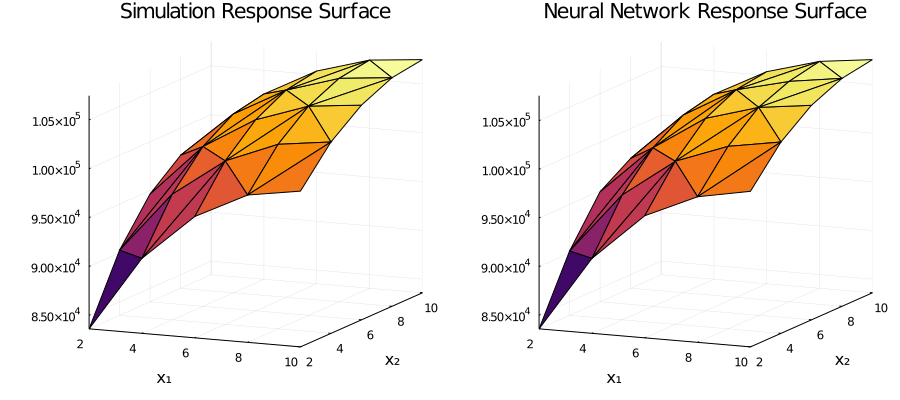

In [79]:
plot(
    surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface", legend=false),
    surface([x[1] for x in X], [x[2] for x in X], [inv_z_transform(nn(x, W1, b1, W2, b2)) for (x,y) in zip(X,y)], title="Neural Network Response Surface", legend=false),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂",
    margin=5Plots.mm
)

In [80]:
savefig("simulation_response_surface.pdf")

---

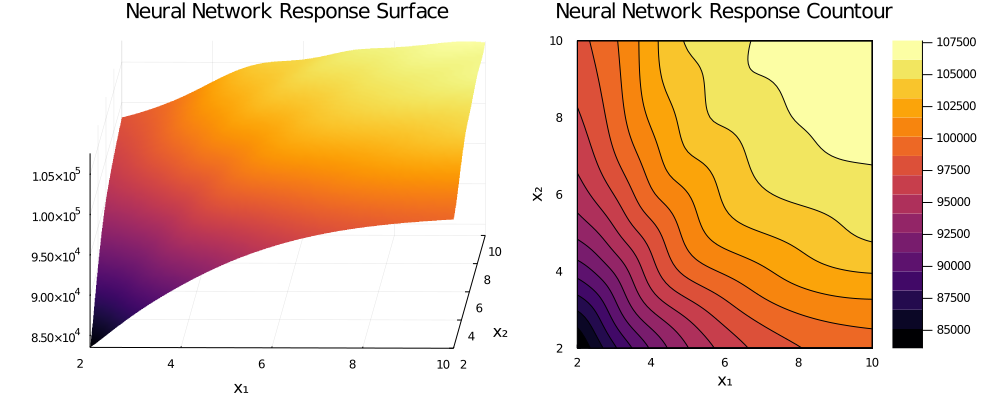

In [39]:
function plot_surface()
    plot(
        st=:surface,
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        camera=(5,45),
        legend=false,
        title="Neural Network Response Surface"
    )
end

function plot_contour()
    contourf(
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        title="Neural Network Response Countour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

In [40]:
savefig("nn_response_surface.pdf")

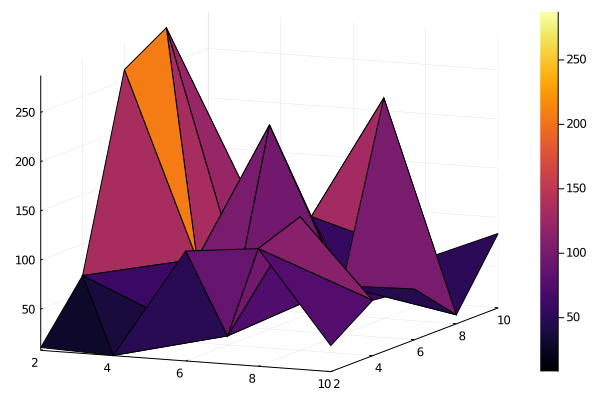

In [41]:
surface([x[1] for x in X], [x[2] for x in X], [abs((yi .- inv_z_transform.(nn(xi, W1, b1, W2, b2)))[1]) for (xi,yi) in zip(X,y)])

In [22]:
for x in [[0.2, 0.5], [0.3, 0.9], [0.1, 0.9]]
    gain_nn = inv_z_transform(nn(x, W1, b1, W2, b2))[1]
    gain_simulation = simulate(M, x[1], x[2])
    println("Gain NN: $(@sprintf("%d", gain_nn)), Gain Simulation: $(@sprintf("%d", gain_simulation))")
end

Gain NN: 86110, Gain Simulation: 58390
Gain NN: 82789, Gain Simulation: 63839
Gain NN: 83779, Gain Simulation: 60025


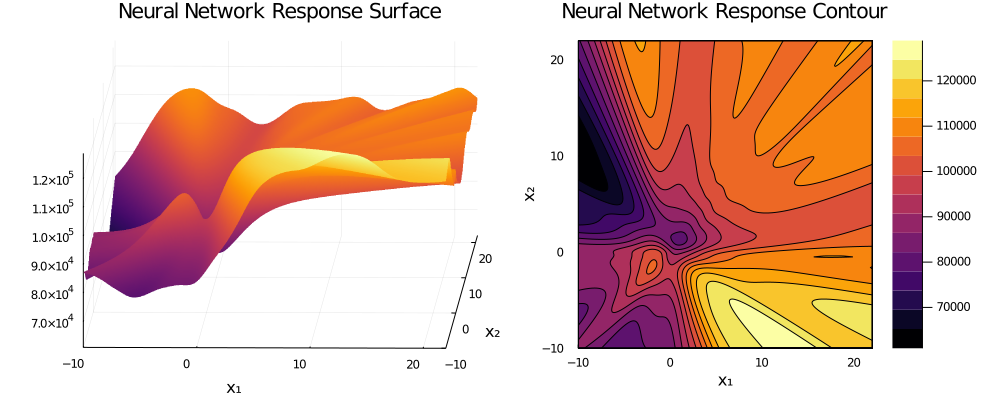

In [42]:
axis_range = -10:0.1:22
function plot_surface()
    plot(
        st=:surface,
        axis_range,
        axis_range,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        camera=(5,45),
        title="Neural Network Response Surface",
        legend=false
    )
end

function plot_contour()
    contourf(
        axis_range,
        axis_range,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        title="Neural Network Response Contour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

In [43]:
savefig("nn_response_surface_extended.pdf")

---

In [24]:
# Find the maximum of the surrogate model using the spall method for
# stochastic gradient ascent
function maximize_gain(;verbose = false)
    # Iteration counter
    m = 1
    m_max = 1000
    
    # Random starting poing
    x = [rand(2:2:10), rand(2:2:10)]
    
    # Gradient ascent step length
    mu = 5e-2
    
    C = 0.1
    
    # Array to save the ascent's visited points
    trajectory = []
    
    while m < m_max
        # Compute a random vector of +-1
        h = rand([1, -1], size(x, 1))
        
        # compute the finite difference step length
        c = C / m^0.2
        
        nn_pred = inv_z_transform(nn(x, W1, b1, W2, b2))
        if verbose
            println("x=$(round.(x, digits=2)), nn=$(round(nn_pred, digits=1)), c=$(round(c, digits=3))")
        end
            
        if m % 1 == 0
            push!(trajectory, x)
        end
        
        # compute the derivative of the neural network w.r.t input using Spall's method
        finite_diff = inv_z_transform(nn(x + c*h, W1, b1, W2, b2)) - inv_z_transform(nn(x - c*h, W1, b1, W2, b2))
        dx = [finite_diff / 2*c*h[i] for i in 1:size(x, 1)]

        # gradient ascent step
        x_new = x + mu * dx
        
        if (norm(x - x_new)) / norm(x_new) < 1e-4
            verbose && println("Hit termination condition at m=$m, x=$(round.(x, digits=2))")
            break
        end
        
        x = x_new
        
        m += 1
    end
    
    if m == m_max
        verbose && println("Maximum number of iterations reached, m=$m")
    end
    
    return trajectory
end
maximize_gain(verbose = true)
nothing

x=[2.0, 4.0], nn=90205.9, c=0.1
x=[1.22, 4.78], nn=91533.9, c=0.087
x=[0.75, 5.25], nn=92082.2, c=0.08
x=[1.52, 6.01], nn=94086.2, c=0.076
x=[2.35, 6.84], nn=96710.1, c=0.072
x=[3.24, 7.73], nn=99789.5, c=0.07
x=[3.75, 7.22], nn=100617.4, c=0.068
x=[4.05, 6.91], nn=101058.0, c=0.066
x=[4.79, 7.65], nn=103201.6, c=0.064
x=[5.3, 8.16], nn=104317.7, c=0.063
x=[5.57, 7.89], nn=104549.3, c=0.062
x=[5.91, 8.22], nn=105086.7, c=0.061
x=[5.9, 8.24], nn=105087.3, c=0.06
x=[5.89, 8.24], nn=105087.3, c=0.059
x=[6.15, 8.49], nn=105437.8, c=0.058
x=[6.13, 8.52], nn=105439.7, c=0.057
x=[6.34, 8.73], nn=105699.7, c=0.057
x=[6.53, 8.91], nn=105904.3, c=0.056
x=[6.69, 9.08], nn=106070.9, c=0.055
x=[6.84, 9.23], nn=106210.2, c=0.055
x=[6.81, 9.26], nn=106216.9, c=0.054
x=[6.79, 9.28], nn=106218.6, c=0.054
x=[6.78, 9.29], nn=106219.0, c=0.053
x=[6.78, 9.29], nn=106219.1, c=0.053
x=[6.91, 9.42], nn=106332.8, c=0.053
x=[7.03, 9.54], nn=106432.0, c=0.052
x=[7.02, 9.55], nn=106432.6, c=0.052
x=[7.01, 9.55], 

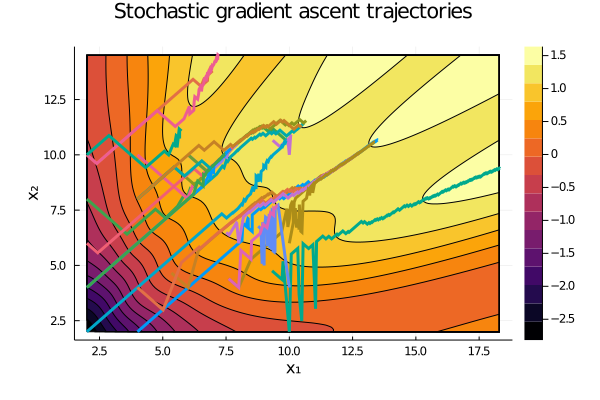

In [51]:
trajectories = [maximize_gain(; verbose=false) for i in 1:25];

min_x = minimum([minimum([p[1] for p in trj]) for trj in trajectories])
max_x = maximum([maximum([p[1] for p in trj]) for trj in trajectories])
min_y = minimum([minimum([p[2] for p in trj]) for trj in trajectories])
max_y = maximum([maximum([p[2] for p in trj]) for trj in trajectories])
nothing

p = contourf(
    min_x:0.1:max_x,
    min_y:0.1:max_y,
    (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
    title="Stochastic gradient ascent trajectories",
    xlabel="x₁", ylabel="x₂", margin=5Plots.mm
)
for (i, trj) in enumerate(trajectories)  
    plot!(st=:line, [p[1] for p in trj], [p[2] for p in trj], legend=false, color=i, lw=3)
end
p

In [52]:
savefig("trajectories.pdf")

---

In [53]:
test = [@time simulate(M, x1, x2) for x1=2:2:20, x2=2:2:20]

  0.312056 seconds (2.46 M allocations: 69.505 MiB, 10.63% gc time)
  0.272177 seconds (2.47 M allocations: 69.705 MiB, 9.43% gc time)
  0.262722 seconds (2.47 M allocations: 69.729 MiB, 4.42% gc time)
  0.259111 seconds (2.47 M allocations: 69.732 MiB, 7.52% gc time)
  0.258840 seconds (2.47 M allocations: 69.732 MiB, 7.50% gc time)
  0.253737 seconds (2.47 M allocations: 69.732 MiB, 4.01% gc time)
  0.261592 seconds (2.47 M allocations: 69.729 MiB, 7.46% gc time)
  0.252335 seconds (2.47 M allocations: 69.704 MiB, 3.84% gc time)
  0.265335 seconds (2.45 M allocations: 69.498 MiB, 7.37% gc time)
  0.274014 seconds (2.23 M allocations: 66.079 MiB, 3.60% gc time)
  0.264604 seconds (2.47 M allocations: 69.688 MiB, 7.40% gc time)
  0.253457 seconds (2.47 M allocations: 69.727 MiB, 7.78% gc time)
  0.245035 seconds (2.47 M allocations: 69.732 MiB, 3.95% gc time)
  0.251366 seconds (2.47 M allocations: 69.733 MiB, 7.71% gc time)
  0.242979 seconds (2.47 M allocations: 69.733 MiB, 4.04% gc 

10×10 Array{Float64,2}:
 83613.1  90276.1        94660.7        …  90278.4        83591.1  68458.2
 91264.4  96494.7        99922.8           96513.8        91289.8  79559.6
 96025.4      1.0033e5       1.03186e5         1.0034e5   96033.4  86342.1
 98678.3      1.02486e5      1.05015e5         1.02506e5  98677.4  90129.7
 99546.4      1.03208e5      1.05615e5         1.03198e5  99544.8  91346.2
 98667.4      1.02488e5      1.0501e5   …      1.02497e5  98675.0  90114.2
 96021.7      1.0033e5       1.03182e5         1.00337e5  96008.2  86352.3
 91302.0  96500.4        99965.7           96468.9        91272.3  79551.4
 83609.0  90301.7        94666.5           90285.4        83586.3  68486.7
 63557.9  74158.4        81060.0           74196.2        63575.2  39101.0

  0.224194 seconds (233.61 k allocations: 12.273 MiB)


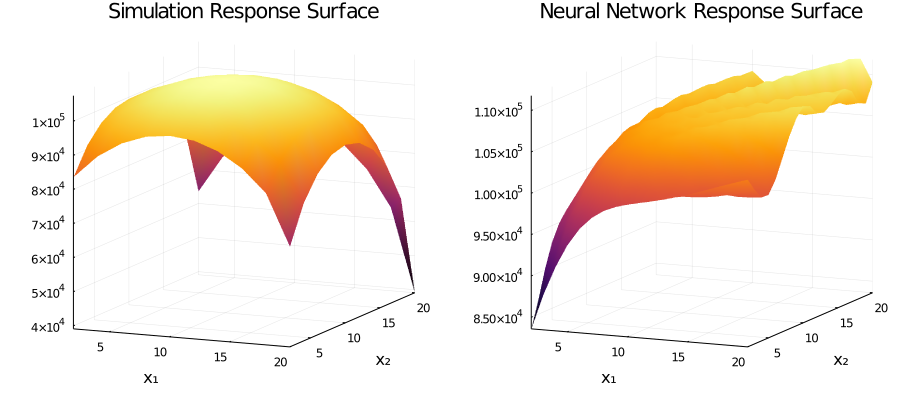

In [67]:
@time plot(
    surface(
        2:2:20, 2:2:20,
        test,
        title="Simulation Response Surface",
        legend=false
    ),
    surface(
            2:1:20,
            2:1:20,
            (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
            legend=false,
            title="Neural Network Response Surface"
    ),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂",
    margin=5Plots.mm
)

In [68]:
savefig("real.pdf")

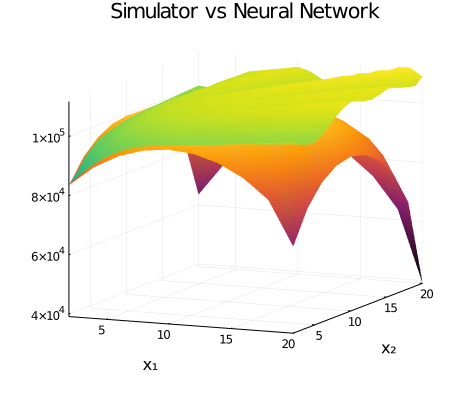

In [77]:
surface(
    2:2:20, 2:2:20,
    test,
    legend=false,
    xlabel="x₁", ylabel="x₂",
    margin=5Plots.mm,
    size=(450, 400)
)
surface!(
        2:1:20,
        2:1:20,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        legend=false,
        c=:viridis,
)
title!("Simulator vs Neural Network")

In [78]:
savefig("nn_over_simulator.pdf")